In [1]:
import os
import pathlib

In [2]:
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    print(f"TF Models missing")

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [5]:
def get_keypoint_tuples(eval_config):
    tuple_list = []
    kp_list = eval_config.keypoint_edge
    for edge in kp_list:
        tuple_list.append((edge.start, edge.end))
    return tuple_list

In [6]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {
    'centernet_with_keypoints': 'center_net_hourglass104_512x512_coco17_tpu-8', 
    'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8'
}

model_display_name = 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

In [7]:
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/', model_name + '.config')
model_dir = '/Users/shankar/dev/code/ds/object_detection/data/models/centernet/centernet_keypoints/centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint'

In [8]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
    model_config=model_config,
    is_training=False
)

In [9]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

In [10]:
def get_model_detection_function(model):
    @tf.function
    def detect_fn(image):
        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)
        
        return detections, prediction_dict, tf.reshape(shapes, [-1])
    
    return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [11]:
label_map_path = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True
)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [57]:
image_dir = 'models/research/object_detection/test_images/'
image_dir = '../model_explanation/'
image_path = os.path.join(image_dir, 'newyork_2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things the try
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Conver to grayscale
#image_np = np.tile(np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32
)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

In [58]:
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
    keypoints = detections['detection_keypoints'][0].numpy()
    keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

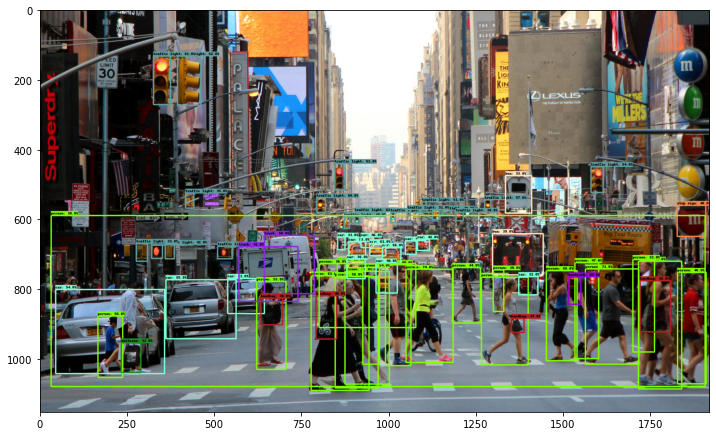

In [59]:
viz_utils.visualize_boxes_and_labels_on_image_array (
    image_np_with_detections,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.30,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=get_keypoint_tuples(configs['eval_config'])
)

plt.figure(figsize=(12, 16))
plt.imshow(image_np_with_detections)
plt.show()

### Intermediate Predictions - Visualizing Intermediate Classes
- Using CenterNet model [Object as Points](https://arxiv.org/abs/1904.07850)
- Detection model is of type `meta_architectures.center_net_meta_arch.CenterNetMetaArch`
- CenterNet produces a heatmap of box centers for each class
- Heatmap whose size is proportional to that of the image that lights up at the center of each 

In [60]:
if(detection_model.__class__.__name__ != 'CenterNetMetaArch'):
    raise AssertionError('The meta-architecture for this section '
        'is assumed to be CenterNetMetaArch!')


In [61]:
"""
Grabs class center logits and apply inverse logit transform.

Args:
    predictions_dict: dictionary of tensors containing a `object_center`
    field of shape [1, heatmap_width, heatmap_height, num_classes]
    class_name: string name of category (e.g. `horse`)
    
Returns:
    heatmap: 2d Tensor heatmap representing heatmap of centers for a given class
    (For CenterNet, this is 128x128 or 256x256) with values in [0, 1]
"""    
def get_heatmap(predictions_dict, class_name):
    class_index = label_map_dict[class_name]
    class_center_logits = predictions_dict['object_center'][0]
    class_center_logits = class_center_logits[0][
        :, :, class_index - label_id_offset
    ]
    heatmap = tf.exp(class_center_logits) / (tf.exp(class_center_logits) + 1)
    return heatmap

In [62]:
"""
Reshapes/unpads heatmap appropriately

  Args:
    heatmap: Output of `get_heatmap`, a 2d Tensor
    image_np: uint8 numpy array with shape (img_height, img_width, 3).  Note
      that due to padding, the relationship between img_height and img_width
      might not be a simple scaling.

  Returns:
    resized_heatmap_unpadded: a resized heatmap (2d Tensor) that is the same
      size as `image_np`
"""
def unpad_heatmap(heatmap, image_np):
    heatmap = tf.tile(tf.expand_dims(heatmap, 2), [1, 1, 3]) * 255
    pre_strided_size = detection_model._stride * heatmap.shape[0]
    resized_heatmap = tf.image.resize(
        heatmap, [pre_strided_size, pre_strided_size],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    resized_heatmap_unpadded = tf.slice(resized_heatmap, begin=[0, 0, 0], size=shapes)
    return tf.image.resize(
        resized_heatmap_unpadded,
        [image_np.shape[0], image_np.shape[1]],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )[:, :, 0]

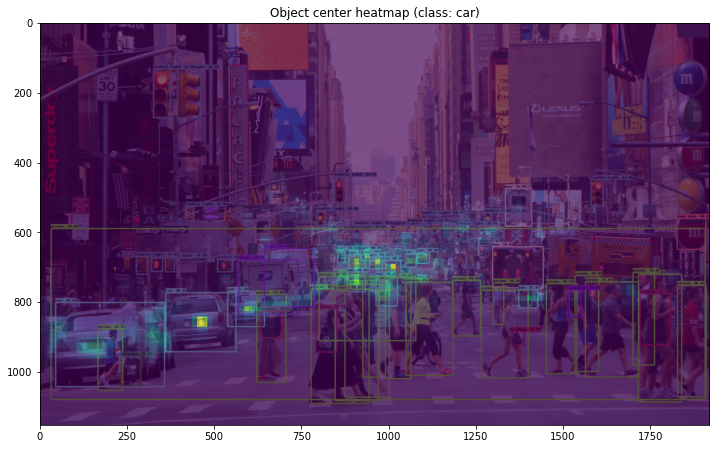

In [65]:
class_name = 'car'
heatmap = get_heatmap(predictions_dict, class_name)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)

plt.figure(figsize=(12, 16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7, vmin=0, vmax=160, cmap='viridis')
plt.title(f'Object center heatmap (class: {class_name})')
plt.show()

In [33]:
!ls ../model_explanation/dock

001_GradCAM_Intro.ipynb      dock_2.jpg
002_GradCAM_Keras.ipynb      imagenet_1000_idx.js
003_Visualizing_CNN.ipynb    motor_boat.jpg
004_MultiClass_GradCAM.ipynb newyork.jpg
005_The_Paper.ipynb          newyork_2.jpg
anime.gif                    pier.jpg
boat_2.jpg                   superimposed_image.jpg
dock.gif                     vgg16_dock.png
dock.jpg                     xception.png
